In [ ]:
import numpy as np
import numpy.linalg as LA
from scipy.integrate import quad
from scipy.interpolate import interp1d
from matplotlib import pyplot as plt

In [ ]:
from NACA_63210 import airfoil_surface
from Lift_diagrams import chord, V_distribution, M_distribution, T_distribution, q, Cn_distribution, dynamic_p

In [ ]:
b2 = 16.07/2
root_c = 2.46 
tip_c = 1.11
E = 68.9 * 10 ** 9
G = 26 * 10 ** 9
UTS = 290 * 10 ** 6
YieldStregth = 240 * 10 ** 6
rho_al = 2700
y = np.linspace(0, b2, 800)
rho_FL330 = 0.418501741
q_crit = dynamic_p(rho_FL330, 250.18)
CL_crit = 0.514

def chord_length(y):
    """Returns chord length at spanwise posistion"""
    return root_c + y * (tip_c - root_c)/b2

In [143]:
class Panel:
    def __init__(self, point1, point2, thickness):
        """point1 and point2 are coordinates relative to the chord, thickness in mm"""
        self.p1 = point1
        self.p2 = point2
        self.vector = point2 - point1
        self.h = LA.norm(self.vector)
        self.t = thickness
        # z is the vertical distance from the x axis relative to chord
        self.z = (point1 + self.vector/2)[1]

    def A(self, y):
        return self.h * chord(y) * self.t(y)
    
    def Q_x(self, y):
        """Returns first moment of area about z=0"""
        return self.z * chord(y) * self.A(y)
    
    def I_xc(self, y):
        """Returns second moment of area about own axis"""
        cos_a = self.vector[0] / self.h
        sin_a = self.vector[1] / self.h

        return self.t(y) * (self.h*chord(y)) * (self.t(y)**2 * cos_a**2 + (self.h*chord(y))**2 * sin_a**2) / 12
    
    def I_xx(self, y, z_centroid):
        """Returns second moment of area about centroid"""
        d = self.z * chord(y) - z_centroid
        return self.I_xc(y) + self.A(y) * d**2
    


In [144]:
class Stringer:
    def __init__(self, area, point, length):
        """area is in square mm, point is the coordinate realtive to the chord and length is the spanwise length of the stringer"""
        self.A = area * 1e-6
        self.point = point
        self.length = length
    
    def Q_x(self, y):
        """Returns first moment of area about z=0"""
        return self.A * self.point[1] * chord(y)

    def I_xc(self, y, z_centroid):
        """Returns second moment of area about centroid"""
        
        return self.A * (self.point[1] * chord(y) - z_centroid)**2 


In [145]:
class WingBox:

  def __init__(self, front_spar_x, front_spar_t, rear_spar_x, rear_spar_t, upper_panel_t, lower_panel_t, stringers=None):
                
    front_upper_z, front_lower_z = airfoil_surface(front_spar_x)
    front_upper, front_lower = np.array([front_spar_x, front_upper_z]), np.array([front_spar_x, front_lower_z])
    rear_upper_z, rear_lower_z = airfoil_surface(rear_spar_x)
    rear_upper, rear_lower = np.array([rear_spar_x, rear_upper_z]), np.array([rear_spar_x, rear_lower_z])

    self.points = {"front_upper":front_upper, "front_lower":front_lower, "rear_upper":rear_upper, "rear_lower":rear_lower}

    front_spar = Panel(front_lower, front_upper, front_spar_t)
    rear_spar = Panel(rear_lower, rear_upper, rear_spar_t)
    upper_panel = Panel(front_upper, rear_upper, upper_panel_t)
    lower_panel = Panel(front_lower, rear_lower, lower_panel_t)

    self.panels = {"front_spar":front_spar, "rear_spar":rear_spar, "upper_panel":upper_panel, "lower_panel":lower_panel} 
  
    self.stringers = stringers

  def A(self, y):
    A = 0
    for panel in self.panels.values():
      A += panel.A(y)
    
    if self.stringers is not None:
      for stringer in self.stringers:
        if stringer.length < y:
          pass
        else:
          A += stringer.A
    return A
  
  def w(self, y):
    return self.A(y)*rho_al

  def W(self):
    return quad(self.w, 0, b2)[0] * 2

  def I_xc(self, y):
    c = chord(y)
    A = 0
    Az = 0
    I_xc = 0

    for panel in self.panels.values():
      A += panel.A(y)
      Az += panel.Q_x(y)
    
    if self.stringers is not None:
      for stringer in self.stringers:
        if stringer.length < y:
          pass
        else:
          A += stringer.A
          Az += stringer.Q_x(y) 
    
    z_centroid = Az / A

    for panel in self.panels.values():
      I_xc += panel.I_xx(y, z_centroid)

    if self.stringers is not None:
      for stringer in self.stringers:
        if stringer.length < y:
          pass
        else:
          I_xc += stringer.I_xc(y, z_centroid)

    return I_xc
  
  def J(self, y):
    # Calculate area inside box
    x_distance = self.points["rear_upper"][0] - self.points["front_upper"][0]
    A = x_distance/2*(self.panels["front_spar"].h + self.panels["rear_spar"].h) * chord(y)**2
    integral = 0
    for panel in self.panels.values():
      integral += panel.h * chord(y)/panel.t(y)
    return 4 * A**2 / integral

    

In [146]:
def t(t_start, t_end):
    t_start *= 1e-3
    t_end *= 1e-3
    return lambda y: t_start - (t_start - t_end) / b2 * y


0.001

In [173]:
stringer_u1 = Stringer(50, (0.3, 0.05), 4)
stringer_u2 = Stringer(50, (0.4, 0.05), 4)
stringer_u3 = Stringer(50, (0.5, 0.05), 4)
stringer_l1 = Stringer(50, (0.4, -0.05), 4)
stringers = [stringer_u1, stringer_u2, stringer_u3, stringer_l1]

# wingbox_iteration_1_stringer = WingBox(0.2, t_1, 0.6, t_1, t_1, t_1, stringers=[stringer_u1, stringer_u2, stringer_u3, stringer_l1])
t_5 = t(5, 5)
t_3 = t(3, 3)
t_2 = t(2, 2)
t_1 = t(1, 1)
wingbox_iteration_1 = WingBox(0.2, t_2, 0.6, t_2, t_2, t_2)
wingbox_iteration_2 = WingBox(0.2, t(2,1), 0.6, t(2,1), t(5,1), t(5,1))


In [175]:
wingbox_iteration_1.I_xc(0)

6.190252078336808e-05

In [130]:
V = V_distribution(CL_crit, q_crit)
M = M_distribution(V)
T = T_distribution(CL_crit, q_crit)


NameError: name 'CL_crit' is not defined

DISPLACEMENT

In [ ]:
def d2zdx2(y, wingbox: WingBox):
    """calculate second derivative of the displacement"""
    return -(M(y)/E/wingbox.I_xc(y))


def dzdx(y, wingbox: WingBox):
    """calculate first derivative through integration"""
    y_range = np.linspace(0, b2, 800)
    func = interp1d(y_range, d2zdx2(y_range, wingbox), kind='cubic', fill_value='extrapolate')
    return [quad(func, 0, i)[0] for i in y]
    

def z(y, wingbox: WingBox):
    """calculate displacement through integration"""
    y_range = np.linspace(0, b2, 800)
    func = interp1d(y_range, dzdx(y_range, wingbox), kind='cubic', fill_value='extrapolate')
    return [quad(func, 0, i)[0] for i in y]

zperc = lambda y: z(y, wingbox_iteration_1) / b2 * 50

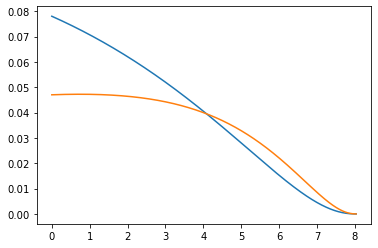

In [176]:
plt.plot(y, d2zdx2(y, wingbox_iteration_1))
plt.plot(y, d2zdx2(y, wingbox_iteration_2))

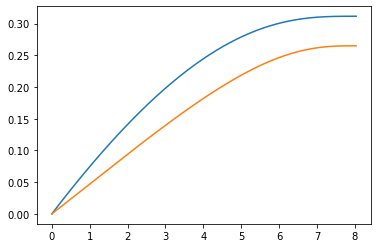

In [177]:
plt.plot(y, dzdx(y, wingbox_iteration_1))
plt.plot(y, dzdx(y, wingbox_iteration_2))

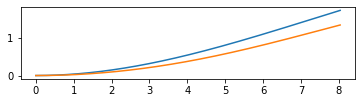

In [178]:
plt.plot(y, z(y, wingbox_iteration_1))
plt.plot(y, z(y, wingbox_iteration_2))
plt.gca().set_aspect('equal', adjustable='box')

ROTATION

In [156]:
def dthetadx(y, wingbox: WingBox):
    """calculate first derivative of the rotation"""
    return T(y)*G/wingbox.J(y)

def theta(y, wingbox: WingBox):
    """calculate rotation through integration"""
    y_range = np.linspace(0, b2, 800)
    func = interp1d(y_range, dthetadx(y, wingbox), kind='cubic', fill_value='extrapolate')
    return [quad(func, 0, i)[0] * 180 / np.pi for i in y]
    

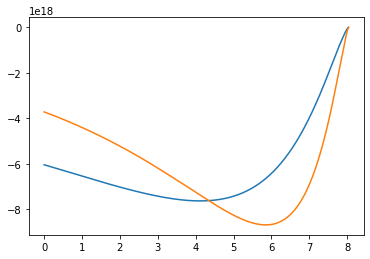

In [180]:
plt.plot(y,dthetadx(y, wingbox_iteration_1))
plt.plot(y,dthetadx(y, wingbox_iteration_2))

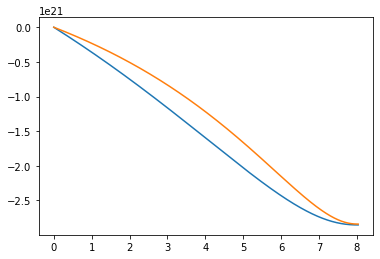

In [181]:
plt.plot(y,theta(y, wingbox_iteration_1))
plt.plot(y,theta(y, wingbox_iteration_2))